# xLSTM 1M Datasets

In [12]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys

# Install required packages:
# pip install mlstm_kernels
# pip install xlstm

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download and extract MovieLens 1M dataset
# -----------------------------

DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "ml-1m"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 1M dataset...")
    r = requests.get(DATA_URL)
    with open("ml-1m.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and process data
# -----------------------------

print("Loading data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
print("Sample ratings:")
print(rating_df.head())

rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)

user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)
print(f"Number of users: {num_users}, Number of items: {num_items}")

user_seqs = rating_df.groupby('user_id')['movie_id'].apply(list).to_dict()

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

class MovieLensDataset(Dataset):
    def __init__(self, user_sequences, max_len=50):
        self.samples = []
        self.max_len = max_len
        for user, items in user_sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

train_dataset = MovieLensDataset(user_seqs, max_len=50)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# -----------------------------
# 4. True xLSTM Large Model
# -----------------------------

xlstm_config = xLSTMLargeConfig(
    embedding_dim=512,
    num_heads=4,
    num_blocks=6,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

model = xLSTMLarge(xlstm_config)
print("xLSTM Model Architecture:")
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -----------------------------
# 5. Evaluation Metrics
# -----------------------------

def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            recall += 1
            rank = pred[:k].index(target)
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training Loop
# -----------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in train_loader:
            seqs = seqs.to(device)
            outputs = model(seqs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

# -----------------------------
# 7. Plotting results
# -----------------------------

plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Sample Predictions
# -----------------------------

print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (seq, target) in enumerate(sample_loader):
        seq = seq.to(device)
        outputs = model(seq)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        top10 = torch.topk(logits, k=10, dim=-1).indices.cpu().squeeze().tolist()
        print(f"Input sequence: {seq.cpu().squeeze().tolist()}")
        print(f"True next item: {target.item()}")
        print(f"Top-10 Predictions: {top10}\n")
        if i == 4:
            break

Loading data...
Sample ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
Number of users: 6040, Number of items: 3706
xLSTM Model Architecture:
xLSTMLarge(
  (embedding): Embedding(3707, 512)
  (backbone): xLSTMLargeBlockStack(
    (blocks): ModuleList(
      (0-5): 6 x mLSTMBlock(
        (norm_mlstm): RMSNorm()
        (mlstm_layer): mLSTMLayer(
          (q): Linear(in_features=512, out_features=256, bias=False)
          (k): Linear(in_features=512, out_features=256, bias=False)
          (v): Linear(in_features=512, out_features=512, bias=False)
          (ogate_preact): Linear(in_features=512, out_features=512, bias=False)
          (igate_preact): Linear(in_features=512, out_features=4, bias=True)
          (fgate_preact): Linear(in_features=512, out_features=4, bias=True)
          

100%|██████████| 7767/7767 [11:06<00:00, 11.66it/s]


Epoch 1 | Loss: 49506.4282 | Recall@10: 0.2125 | MRR@10: 0.0879 | NDCG@10: 0.1169


 59%|█████▉    | 4601/7767 [06:16<04:18, 12.23it/s]


KeyboardInterrupt: 

# LSTM 1M

Loading data...
Sample ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
Number of users: 6040, Number of items: 3706

Starting training...


100%|██████████| 7767/7767 [00:37<00:00, 206.48it/s]


Epoch 1 | Loss: 49597.2906 | Recall@10: 0.1966 | MRR@10: 0.0748 | NDCG@10: 0.1030


100%|██████████| 7767/7767 [00:36<00:00, 211.06it/s]


Epoch 2 | Loss: 44632.0847 | Recall@10: 0.2272 | MRR@10: 0.0905 | NDCG@10: 0.1222


100%|██████████| 7767/7767 [00:37<00:00, 208.75it/s]


Epoch 3 | Loss: 43452.0213 | Recall@10: 0.2441 | MRR@10: 0.1000 | NDCG@10: 0.1335


100%|██████████| 7767/7767 [00:36<00:00, 210.86it/s]


Epoch 4 | Loss: 42795.8851 | Recall@10: 0.2565 | MRR@10: 0.1067 | NDCG@10: 0.1415


100%|██████████| 7767/7767 [00:36<00:00, 212.05it/s]


Epoch 5 | Loss: 42345.9082 | Recall@10: 0.2662 | MRR@10: 0.1119 | NDCG@10: 0.1478


100%|██████████| 7767/7767 [00:36<00:00, 210.29it/s]


Epoch 6 | Loss: 42009.8025 | Recall@10: 0.2731 | MRR@10: 0.1154 | NDCG@10: 0.1521


100%|██████████| 7767/7767 [00:36<00:00, 211.03it/s]


Epoch 7 | Loss: 41742.6509 | Recall@10: 0.2801 | MRR@10: 0.1192 | NDCG@10: 0.1567


100%|██████████| 7767/7767 [00:37<00:00, 209.85it/s]


Epoch 8 | Loss: 41519.3403 | Recall@10: 0.2848 | MRR@10: 0.1216 | NDCG@10: 0.1596


100%|██████████| 7767/7767 [00:36<00:00, 210.37it/s]


Epoch 9 | Loss: 41331.8780 | Recall@10: 0.2898 | MRR@10: 0.1244 | NDCG@10: 0.1629


100%|██████████| 7767/7767 [00:36<00:00, 210.66it/s]


Epoch 10 | Loss: 41170.6377 | Recall@10: 0.2932 | MRR@10: 0.1266 | NDCG@10: 0.1655


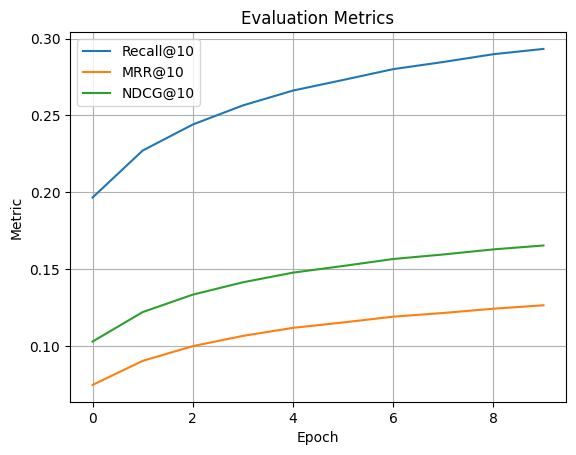


Sample predictions:
Input sequence: [215, 1758, 452, 2814, 902, 762, 1459, 1633, 1136, 540, 996, 1280, 1281, 208, 341, 146, 871, 141, 913, 893, 747, 2110, 489, 876, 1846, 2133, 875, 1913, 2648, 1918, 1054, 210, 576, 1480, 2252, 156, 1401, 157, 397, 756, 153, 161, 2703, 325, 2007, 1635, 186, 828, 438, 6]
True next item: 2273
Top-10 Predictions: [436, 2012, 2065, 95, 2042, 14, 521, 828, 1959, 2718]

Input sequence: [88, 217, 183, 111, 214, 594, 208, 1254, 1028, 432, 632, 132, 1026, 439, 189, 143, 148, 185, 1029, 1027, 136, 840, 754, 163, 191, 1003, 843, 12, 751, 87, 181, 258, 609, 101, 742, 134, 141, 192, 190, 44, 33, 519, 196, 62, 520, 199, 127, 2003, 1, 267]
True next item: 891
Top-10 Predictions: [13, 270, 273, 271, 267, 60, 564, 552, 78, 130]

Input sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 774, 218, 662]
True next item: 65
Top-10 Predictions: [9, 54, 16, 15, 53, 41, 430, 55

In [3]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# -----------------------------
# 1. Download and extract MovieLens 1M dataset
# -----------------------------

DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "ml-1m"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 1M dataset...")
    r = requests.get(DATA_URL)
    with open("ml-1m.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and process data
# -----------------------------

print("Loading data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
print("Sample ratings:")
print(rating_df.head())

# Sort by timestamp for each user
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Map to contiguous IDs
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)

print(f"Number of users: {num_users}, Number of items: {num_items}")

# Group by user
user_seqs = rating_df.groupby('user_id')['movie_id'].apply(list).to_dict()

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

class MovieLensDataset(Dataset):
    def __init__(self, user_sequences, max_len=50):
        self.samples = []
        self.max_len = max_len
        for user, items in user_sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

train_dataset = MovieLensDataset(user_seqs)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# -----------------------------
# 4. xLSTM Model (simple version)
# -----------------------------

class xLSTM(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=64):
        super(xLSTM, self).__init__()
        self.embedding = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, num_items)

    def forward(self, x):
        emb = self.embedding(x)
        output, _ = self.lstm(emb)
        final_hidden = output[:, -1, :]
        logits = self.output(final_hidden)
        return logits

# -----------------------------
# 5. Evaluation Metrics
# -----------------------------

def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            recall += 1
            rank = pred[:k].index(target)
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training Loop
# -----------------------------

model = xLSTM(num_items)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(seqs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in train_loader:
            seqs = seqs.to(device)
            logits = model(seqs)
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

# -----------------------------
# 7. Plotting results
# -----------------------------

plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Sample Predictions
# -----------------------------

print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (seq, target) in enumerate(sample_loader):
        seq = seq.to(device)
        logits = model(seq)
        top10 = torch.topk(logits, k=10, dim=-1).indices.cpu().squeeze().tolist()
        print(f"Input sequence: {seq.cpu().squeeze().tolist()}")
        print(f"True next item: {target.item()}")
        print(f"Top-10 Predictions: {top10}\n")
        if i == 4:
            break


In [ ]:
# 1. Importing Packages

import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# --- GPU Setup and Debug ---
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Show all TF logs
# tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU(s) detected and memory growth enabled:", gpus)
    except RuntimeError as e:
        print("⚠️ RuntimeError while enabling memory growth:", e)
else:
    print("❌ No GPU detected. Training will run on CPU.")


✅ GPU(s) detected and memory growth enabled: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 2. Loading Data
start = time.time()
url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
print("Data loaded in", round((time.time() - start)/60, 2), "minutes")
print(df.head())


Data loaded in 0.09 minutes
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [ ]:
# 3. Preprocess Data
start = time.time()
df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)
df = df.sort_values(by=['user_id', 'timestamp'])
print("Preprocessing done in", round((time.time() - start)/60, 2), "minutes")
print(df.head())

Preprocessing done in 0.0 minutes
       user_id item_id  rating  timestamp  age gender  occupation zip_code  \
59972        1     168       5  874965478   24      M  technician    85711   
92487        1     172       5  874965478   24      M  technician    85711   
74577        1     165       5  874965518   24      M  technician    85711   
48214        1     156       4  874965556   24      M  technician    85711   
15764        1     196       5  874965677   24      M  technician    85711   

                                        title release_date  ...  Fantasy  \
59972  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
92487         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
74577                 Jean de Florette (1986)  01-Jan-1986  ...        0   
48214                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
15764               Dead Poets Society (1989)  01-Jan-1989  ...        0   

       Film-Noir  Horror  Musical  Myste

In [ ]:
# 4. Create item mappings and train-test split
start = time.time()
unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}
print("Mappings created in", round((time.time() - start)/60, 2), "minutes")
print(list(item_to_idx.items())[:5])

# Train-test split per user
start = time.time()
def user_based_split(data, test_ratio=0.2):
    train_rows, test_rows = [], []
    for _, group in data.groupby('user_id'):
        n_test = int(len(group) * test_ratio)
        group_sorted = group.sort_values(by='timestamp')
        if n_test > 0:
            test_rows.append(group_sorted.tail(n_test))
            train_rows.append(group_sorted.head(len(group) - n_test))
        else:
            train_rows.append(group_sorted)
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)
    return train_df, test_df

train_df, test_df = user_based_split(df, test_ratio=0.2)
print("Train-test split done in", round((time.time() - start)/60, 2), "minutes")
print(train_df.head())
print(test_df.head())

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

Mappings created in 0.0 minutes
[('168', 1), ('172', 2), ('165', 3), ('156', 4), ('196', 5)]
Train-test split done in 0.01 minutes
       user_id item_id  rating  timestamp  age gender  occupation zip_code  \
59972        1     168       5  874965478   24      M  technician    85711   
92487        1     172       5  874965478   24      M  technician    85711   
74577        1     165       5  874965518   24      M  technician    85711   
48214        1     156       4  874965556   24      M  technician    85711   
15764        1     196       5  874965677   24      M  technician    85711   

                                        title release_date  ...  Fantasy  \
59972  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
92487         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
74577                 Jean de Florette (1986)  01-Jan-1986  ...        0   
48214                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
15764               

In [ ]:
# 5. Sequence Tokenization & Creation (Extended with User and Genre Info)
start = time.time()

# Prepare genre vector lookup
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_lookup = movies.set_index('item_id')[genre_columns].astype('float32').to_dict('index')

# Prepare user feature lookup
user_feature_lookup = users.set_index('user_id')[['age', 'gender', 'occupation']].copy()
user_feature_lookup['gender'] = user_feature_lookup['gender'].map({'M': 0, 'F': 1})
user_feature_lookup['occupation'] = user_feature_lookup['occupation'].astype('category').cat.codes
user_feature_lookup = user_feature_lookup.astype('float32').to_dict('index')

# Tokenize item_id sequences
print("Tokenizing item_id sequences...")
def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

print("Tokenization complete in", round((time.time() - start)/60, 2), "minutes")
print("\nTrain Sequence Stats:")
train_lens = train_sequences['item_id'].apply(len)
print(f"Number of users with sequences: {len(train_sequences)}")
print(f"Average sequence length per user: {train_lens.mean():.2f}")
print(f"Max sequence length in any user: {train_lens.max()}")

print("\nTest Sequence Stats:")
test_lens = test_sequences['item_id'].apply(len)
print(f"Number of users with sequences: {len(test_sequences)}")
print(f"Average sequence length per user: {test_lens.mean():.2f}")
print(f"Max sequence length in any user: {test_lens.max()}")

start = time.time()
max_seq_len = 150

def create_sequences(sequences, dataset_type):
    input_seqs, labels, user_feats, genre_seqs = [], [], [], []
    drop_count = 0

    for _, row in sequences.iterrows():
        user_id = row['user_id']
        seq = row['item_id']
        if len(seq) < 2:
            drop_count += 1
            continue

        ufeat = user_feature_lookup.get(user_id, {'age': 0, 'gender': 0, 'occupation': 0})
        ufeat_vec = [ufeat['age'], ufeat['gender'], ufeat['occupation']]

        for i in range(1, len(seq)):
            input_seq = seq[max(0, i - max_seq_len):i]
            label = seq[i]
            input_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
            genre_seq = [genre_lookup.get(idx_to_item.get(i, '0'), dict.fromkeys(genre_columns, 0.0)) for i in input_seq]
            genre_seq = [[g[k] for k in genre_columns] for g in genre_seq]

            input_seqs.append(input_seq)
            labels.append(label)
            user_feats.append(ufeat_vec)
            genre_seqs.append(genre_seq)

    print(f"Total {dataset_type} sequences created: {len(input_seqs)}")
    print(f"Dropped {drop_count} user sequences due to insufficient length.")
    return (np.array(input_seqs, dtype=np.int32),
            np.array(labels, dtype=np.int32),
            np.array(user_feats, dtype=np.float32),
            np.array(genre_seqs, dtype=np.float32))

train_input, train_labels, train_user_feats, train_genres = create_sequences(train_sequences, 'train')
test_input, test_labels, test_user_feats, test_genres = create_sequences(test_sequences, 'test')

print("Sequence creation done in", round((time.time() - start)/60, 2), "minutes")
print(f"Train input shape: {train_input.shape}, Labels shape: {train_labels.shape}")
print(f"Test input shape: {test_input.shape}, Labels shape: {test_labels.shape}")

print("\nSample padded input sequences:")
for i in range(3):
    print(f"Input: {train_input[i][-10:]} ➞ Label: {train_labels[i]} (Movie: {idx_to_title.get(train_labels[i], 'UNK')})")

print("\nSample enriched sequences (Input IDs, Genres, User Features):")
for i in range(3):
    print(f"\n--- Sequence #{i+1} ---")
    print(f"Input IDs:  {train_input[i][-10:]}")
    print(f"Genre vec (last token): {train_genres[i][-1]}")
    print(f"User features: {train_user_feats[i]}")
    print(f"Label: {train_labels[i]} | Title: {idx_to_title.get(train_labels[i], 'UNK')}")

# Print full enriched view for first 3 users
print("\n\nDetailed tokenized view for first 3 users:")
for i in range(3):
    print(f"\n===== User {train_sequences.iloc[i]['user_id']} =====")
    full_seq = train_sequences.iloc[i]['item_id']
    for j in range(min(len(full_seq)-1, 40)):
        token_id = full_seq[j]
        genre_vec = genre_lookup.get(idx_to_item.get(token_id, '0'), dict.fromkeys(genre_columns, 0.0))
        user_feat = user_feature_lookup.get(train_sequences.iloc[i]['user_id'], {})
        print(f"Token {j+1}: ID={token_id}, Genres={[genre_vec[k] for k in genre_columns]}, User Feats={[user_feat.get('age',0), user_feat.get('gender',0), user_feat.get('occupation',0)]}")

num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
num_interactions = len(df)
sparsity = 1 - (num_interactions / (num_users * num_items))
print("\nDataset Statistics:")
print("Dataset    Users    Items    Interactions    Avg. len.    Sparsity")
print(f"ML-100K    {num_users:<9} {num_items:<8} {num_interactions:<15} {train_lens.mean() + test_lens.mean():<13.2f} {sparsity:.4f}")

Tokenizing item_id sequences...
Tokenization complete in 0.0 minutes

Train Sequence Stats:
Number of users with sequences: 943
Average sequence length per user: 85.22
Max sequence length in any user: 590

Test Sequence Stats:
Number of users with sequences: 943
Average sequence length per user: 20.82
Max sequence length in any user: 147
Total train sequences created: 79424
Dropped 0 user sequences due to insufficient length.
Total test sequences created: 18690
Dropped 0 user sequences due to insufficient length.
Sequence creation done in 0.96 minutes
Train input shape: (79424, 150), Labels shape: (79424,)
Test input shape: (18690, 150), Labels shape: (18690,)

Sample padded input sequences:
Input: [0 0 0 0 0 0 0 0 0 1] ➞ Label: 2 (Movie: Empire Strikes Back, The (1980))
Input: [0 0 0 0 0 0 0 0 1 2] ➞ Label: 3 (Movie: Jean de Florette (1986))
Input: [0 0 0 0 0 0 0 1 2 3] ➞ Label: 4 (Movie: Reservoir Dogs (1992))

Sample enriched sequences (Input IDs, Genres, User Features):

--- Sequen

In [ ]:
# 6. Enhanced xLSTM Model to Integrate Genres and User Features
class xLSTM(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=256, num_layers=4, dropout_rate=0.2, max_len=150, genre_dim=18, user_dim=3):
        super(xLSTM, self).__init__()
        self.max_len = max_len
        self.hidden_units = hidden_units

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=hidden_units)

        self.genre_proj = tf.keras.layers.Dense(hidden_units)
        self.user_proj = tf.keras.layers.Dense(hidden_units)
        self.concat_proj = tf.keras.layers.Dense(hidden_units)  # project concatenated input back

        self.mlstm_layers = []
        for _ in range(num_layers // 2):
            conv = tf.keras.layers.Conv1D(filters=hidden_units, kernel_size=3, padding='same')
            attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=hidden_units // 4)
            norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.mlstm_layers.append((conv, attn, norm))

        self.slstm_layers = []
        for idx in range(num_layers // 2):
            lstm = tf.keras.layers.LSTM(hidden_units, return_sequences=(idx < num_layers // 2 - 1), dropout=dropout_rate)
            norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.slstm_layers.append((lstm, norm))

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, genre_seq, user_feats, training=False):
        batch_size = tf.shape(input_ids)[0]
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        positions = tf.broadcast_to(positions, shape=(batch_size, self.max_len))

        print(f"[DEBUG] input_ids shape: {input_ids.shape}")
        print(f"[DEBUG] genre_seq shape: {genre_seq.shape}")
        print(f"[DEBUG] user_feats shape: {user_feats.shape}")
        print(f"[DEBUG] positions shape: {positions.shape}")

        token_embed = self.embedding(input_ids)
        pos_embed = self.pos_embedding(positions)
        genre_embed = self.genre_proj(genre_seq)

        print(f"[DEBUG] token_embed shape: {token_embed.shape}")
        print(f"[DEBUG] pos_embed shape: {pos_embed.shape}")
        print(f"[DEBUG] genre_embed shape: {genre_embed.shape}")

        user_embed = self.user_proj(user_feats)
        user_embed = tf.expand_dims(user_embed, 1)
        user_embed = tf.repeat(user_embed, repeats=self.max_len, axis=1)

        print(f"[DEBUG] user_embed shape after repeat: {user_embed.shape}")

        x = tf.concat([token_embed, pos_embed, genre_embed, user_embed], axis=-1)
        x = self.concat_proj(x)

        print(f"[DEBUG] Combined input (x) shape after concat+proj: {x.shape}")

        for i, (conv, attn, norm) in enumerate(self.mlstm_layers):
            conv_out = conv(x)
            attn_out = attn(conv_out, conv_out)
            x = norm(x + attn_out)
            x = self.dropout(x, training=training)
            print(f"[DEBUG] After MLSTM layer {i+1}: {x.shape}")

        for i, (lstm, norm) in enumerate(self.slstm_layers):
            x = lstm(x, training=training)
            x = norm(x)
            print(f"[DEBUG] After SLSTM layer {i+1}: {x.shape}")

        out = self.output_dense(x)
        print(f"[DEBUG] Final output shape: {out.shape}")
        return out

In [ ]:
# Section 7: Training Loop and Evaluation with Feature Integration
import numpy as np
import time
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected! Please set runtime to GPU.")

# Prepare dataset tuples
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_genres, train_user_feats, train_labels)) \
    .shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_genres, test_user_feats, test_labels)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

metrics_history = {
    "recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []
}

def evaluate_model(model, test_dataset, top_k=10):
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    total_preds = 0

    for batch_inputs, batch_genres, batch_user_feats, batch_labels in test_dataset:
        logits = model(batch_inputs, batch_genres, batch_user_feats, training=False)
        if logits.ndim == 3:
            logits = logits[:, -1, :]
        top_k_preds = tf.math.top_k(logits, k=top_k).indices.numpy()
        targets = batch_labels.numpy()

        for pred, label in zip(top_k_preds, targets):
            total_preds += 1
            if label in pred:
                hit += 1
                recall += 1
                precision += 1 / top_k
                rank = np.where(pred == label)[0][0]
                mrr += 1 / (rank + 1)
                dcg = 1 / np.log2(rank + 2)
            else:
                dcg = 0
            idcg = 1 / np.log2(2)
            ndcg += dcg / idcg

    if total_preds == 0:
        total_preds = 1
    metrics_history["recall@10"].append(recall / total_preds)
    metrics_history["mrr@10"].append(mrr / total_preds)
    metrics_history["ndcg@10"].append(ndcg / total_preds)
    metrics_history["hit@10"].append(hit / total_preds)
    metrics_history["precision@10"].append(precision / total_preds)

# --- Training Loop ---
with tf.device('/GPU:0'):
    model = xLSTM(vocab_size=len(item_to_idx) + 1, max_len=max_seq_len)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    @tf.function
    def train_step(batch_inputs, batch_genres, batch_user_feats, batch_labels):
        with tf.GradientTape() as tape:
            logits = model(batch_inputs, batch_genres, batch_user_feats, training=True)
            if logits.ndim == 3:
                logits = logits[:, -1, :]
            loss = loss_fn(batch_labels, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    start = time.time()
    for epoch in range(30):
        print(f"\nEpoch {epoch+1}/30")
        epoch_loss = 0
        for batch_inputs, batch_genres, batch_user_feats, batch_labels in train_dataset:
            loss = train_step(batch_inputs, batch_genres, batch_user_feats, batch_labels)
            epoch_loss += loss.numpy()

        print(f"Training Loss: {epoch_loss:.4f}")
        print(f"Feeding {batch_inputs.shape[-1]} token IDs, {batch_genres.shape[-1]} genre dims, and {batch_user_feats.shape[-1]} user dims into the model.")

        evaluate_model(model, test_dataset, top_k=10)
        print(f"Evaluation at epoch {epoch+1}: " +
              f"recall@10={metrics_history['recall@10'][-1]:.4f}, " +
              f"mrr@10={metrics_history['mrr@10'][-1]:.4f}, " +
              f"ndcg@10={metrics_history['ndcg@10'][-1]:.4f}, " +
              f"hit@10={metrics_history['hit@10'][-1]:.4f}, " +
              f"precision@10={metrics_history['precision@10'][-1]:.4f}")

    print("Training and evaluation complete in", round((time.time() - start)/60, 2), "minutes")

Streaming output truncated to the last 5000 lines.
[DEBUG] genre_embed shape: (64, 150, 256)
[DEBUG] user_embed shape after repeat: (64, 150, 256)
[DEBUG] Combined input (x) shape after concat+proj: (64, 150, 256)
[DEBUG] After MLSTM layer 1: (64, 150, 256)
[DEBUG] After MLSTM layer 2: (64, 150, 256)
[DEBUG] After SLSTM layer 1: (64, 150, 256)
[DEBUG] After SLSTM layer 2: (64, 256)
[DEBUG] Final output shape: (64, 1683)
[DEBUG] input_ids shape: (64, 150)
[DEBUG] genre_seq shape: (64, 150, 18)
[DEBUG] user_feats shape: (64, 3)
[DEBUG] positions shape: (64, 150)
[DEBUG] token_embed shape: (64, 150, 256)
[DEBUG] pos_embed shape: (64, 150, 256)
[DEBUG] genre_embed shape: (64, 150, 256)
[DEBUG] user_embed shape after repeat: (64, 150, 256)
[DEBUG] Combined input (x) shape after concat+proj: (64, 150, 256)
[DEBUG] After MLSTM layer 1: (64, 150, 256)
[DEBUG] After MLSTM layer 2: (64, 150, 256)
[DEBUG] After SLSTM layer 1: (64, 150, 256)
[DEBUG] After SLSTM layer 2: (64, 256)
[DEBUG] Final out

KeyboardInterrupt: 

In [ ]:
# 8. Updated Plotting
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def explain_top_prediction_for_users(model, sequences, user_ids, top_k=1):
    for uid in user_ids:
        row = sequences[sequences['user_id'] == uid]
        if row.empty:
            continue
        seq = row.iloc[0]['item_id'][-max_seq_len:]
        padded_seq = [0] * (max_seq_len - len(seq)) + seq
        input_tensor = tf.convert_to_tensor([padded_seq], dtype=tf.int32)
        genre_seq = [genre_lookup.get(idx_to_item.get(i, '0'), dict.fromkeys(genre_columns, 0.0)) for i in padded_seq]
        genre_tensor = tf.convert_to_tensor([[list(g.values()) for g in genre_seq]], dtype=tf.float32)
        user_feats = user_feature_lookup.get(uid, {'age': 0, 'gender': 0, 'occupation': 0})
        user_tensor = tf.convert_to_tensor([[user_feats['age'], user_feats['gender'], user_feats['occupation']]], dtype=tf.float32)
        logits = model(input_tensor, genre_tensor, user_tensor, training=False)
        top_k_preds = tf.math.top_k(logits, k=top_k).indices[0].numpy()
        print(f"\nUser ID: {uid} | Recent: {[idx_to_title.get(i, 'UNK') for i in seq if i > 0]}")
        for i, idx in enumerate(top_k_preds):
            print(f"Prediction #{i+1}: {idx_to_title.get(idx, 'UNK')} (ID: {idx})")

In [2]:
!pip install mlstm_kernels
!pip install xlstm

# # OR, for development, from source:
# !pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C


In [2]:
import torch
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

xlstm_config = xLSTMLargeConfig(
    embedding_dim=512,
    num_heads=4,
    num_blocks=6,
    vocab_size=2048,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)
xlstm = xLSTMLarge(xlstm_config).to("cuda")

# Example input: batch of 3, sequence length 256, vocab size 2048
input = torch.randint(0, 2048, (3, 256)).to("cuda")
out = xlstm(input)
print(out.shape)  # Should be (3, 256, 2048)


AttributeError: 'tuple' object has no attribute 'shape'

In [3]:
import sys

sys.path.append("../..")
import torch
import numpy as np

In [4]:
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge
from mlstm_kernels.torch import get_available_mlstm_step_kernels, get_available_mlstm_kernels, get_available_mlstm_sequence_kernels

In [5]:
get_available_mlstm_kernels(), get_available_mlstm_step_kernels(), get_available_mlstm_sequence_kernels()

(['chunkwise--native_autograd',
  'chunkwise--native_custbw',
  'chunkwise--triton_limit_chunk',
  'chunkwise--triton_xl_chunk',
  'chunkwise--triton_xl_chunk_siging',
  'parallel--native_autograd',
  'parallel--native_custbw',
  'parallel--native_stablef_autograd',
  'parallel--native_stablef_custbw',
  'parallel--triton_limit_headdim',
  'parallel--native_siging_autograd',
  'parallel--native_siging_custbw'],
 ['native', 'triton'],
 ['native_sequence__native', 'native_sequence__triton'])

In [6]:

xlstm_config = xLSTMLargeConfig(
    embedding_dim=512,
    num_heads=4,
    num_blocks=6,
    vocab_size=2048,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk", # xl_chunk == TFLA kernels
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

In [7]:
xlstm = xLSTMLarge(xlstm_config)

In [8]:
xlstm

xLSTMLarge(
  (embedding): Embedding(2048, 512)
  (backbone): xLSTMLargeBlockStack(
    (blocks): ModuleList(
      (0-5): 6 x mLSTMBlock(
        (norm_mlstm): RMSNorm()
        (mlstm_layer): mLSTMLayer(
          (q): Linear(in_features=512, out_features=256, bias=False)
          (k): Linear(in_features=512, out_features=256, bias=False)
          (v): Linear(in_features=512, out_features=512, bias=False)
          (ogate_preact): Linear(in_features=512, out_features=512, bias=False)
          (igate_preact): Linear(in_features=512, out_features=4, bias=True)
          (fgate_preact): Linear(in_features=512, out_features=4, bias=True)
          (ogate_act_fn): Sigmoid()
          (mlstm_backend): mLSTMBackend(mLSTMBackendConfig(chunkwise_kernel='chunkwise--triton_xl_chunk', sequence_kernel='native_sequence__triton', step_kernel='triton', mode='inference', chunk_size=64, return_last_states=True, autocast_kernel_dtype='bfloat16', eps=1e-06, inference_state_dtype='float32'))
         